**Brian Tumor Classification**

In [2]:
import glob
import os

from PIL import Image
from PIL import ImageFilter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil


import scikitplot as skplt
from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, load_model

from keras.callbacks import EarlyStopping

from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

from keras import optimizers
from keras.applications.vgg19 import VGG19

from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score
np.random.seed(123)
import itertools

In [13]:
    classes = ['/Astrocitoma', '/Ependimoma', '/Ganglioglioma', '/Germinoma', '/Glioblastoma', '/Granuloma', '/Meduloblastoma',
               '/Meningioma', '/Neurocitoma', '/Normal', '/Oligodendroglioma', '/Papiloma', '/Schwannoma', '/Tuberculoma',
               '/Carcinoma']

In [14]:
def get_tvt_split():
    # Create Train / Val / Test folders
    root_dir = 'data'

    for cl in classes:
        os.makedirs(root_dir + '/train' + cl)
        os.makedirs(root_dir + '/val' + cl)
        os.makedirs(root_dir + '/test' + cl)

    # Create partitions of the data after shuffeling (into 70, 15, 15)
    for currentCls in classes:
        src = "Dataset" + currentCls 
        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                                  [int(len(allFileNames)*0.7), 
                                                                   int(len(allFileNames)*0.85)])
        
        # Name folders
        train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
        test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]
        
        
        # View count of images after partition
        print('Total images: ', len(allFileNames))
        print('Training: ', len(train_FileNames))
        print('Validation: ', len(val_FileNames))
        print('Testing: ', len(test_FileNames))
        
        
        # Copy-paste images
        for name in train_FileNames:
            shutil.copy(name, "data/train"+currentCls)

        for name in val_FileNames:
            shutil.copy(name, "data/val"+currentCls)

        for name in test_FileNames:
            shutil.copy(name, "data/test"+currentCls)

In [15]:
get_tvt_split()

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data/train/Astrocitoma'

This is the total number of images present in respective classes -> [1321, 184, 51, 128, 270, 100, 178, 2521, 613, 1400, 274, 313, 601, 204, 329]

In [48]:
train_folder = '/Users/its/Desktop/Major Project/data/train'
val_folder = '/Users/its/Desktop/Major Project/data/val'
test_folder = '/Users/its/Desktop/Major Project/data/test'

In [ ]:
os.getcwd()

In [ ]:
# Create more blurred + unsharpened photos of MRI's in training data 

for cl in classes:
    os.chdir('/Users/its/Desktop/Major Project/data/train/'+cl)
    filelist = glob.glob("*.jpg") + glob.glob("*.jpeg")
    count = 0
    for imagefile in filelist:
        im = Image.open(imagefile)
        im = im.convert("RGB")
        im_blur = im.filter(ImageFilter.GaussianBlur)
        im_unsharp = im.filter(ImageFilter.UnsharpMask)
        im_blur.save(str(count) + 'bl_' + imagefile)
        im_unsharp.save(str(count) + 'un_' + imagefile)
        count += 1 

In [ ]:
# Make sure count of MRI images in training folder is roughly equal 
for cl in classes:
    print(len(os.listdir('/Users/its/Desktop/Major Project/data/train/'+cl)))

In [ ]:
# Change directory to Astrocitoma Class
os.chdir('/Users/its/Desktop/Major Project/data/train/Astrocitoma')

In [ ]:
# Preview random training photos
for pic_file in  np.random.choice(os.listdir(), 3):
    img = mpimg.imread(pic_file)
    plt.imshow(img)
    plt.show()

In [ ]:
# Change directory to Normal Class
os.chdir('/Users/its/Desktop/Major Project/data/train/Normal')

In [ ]:
# Preview random training photos
for pic_file in  np.random.choice(os.listdir(), 3):
    img = mpimg.imread(pic_file)
    plt.imshow(img)
    plt.show()

In [ ]:
os.chdir('../../..')

In [ ]:
print(os.getcwd())

<h1><strong>Baseline CNN</strong></h1>

In [16]:
# Get model to output 3D feature maps (height, width, features)
model = Sequential()

# Layer 1
model.add(Conv2D(32, (3, 3), input_shape=(228, 228, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [17]:
# Apply flattening function to convert 3D feature maps in to 1D feature vectors
model.add(Flatten())  

# Add 2 final dense layers to add a classifier to the convolutional base
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(15))
model.add(Activation('softmax'))

# Compile the model
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizers.Adam(),
    metrics = ['accuracy']
)

In [18]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 226, 226, 32)      896       
                                                                 
 activation_5 (Activation)   (None, 226, 226, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 113, 113, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 111, 111, 32)      9248      
                                                                 
 activation_6 (Activation)   (None, 111, 111, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                  

**Training the Model**

In [8]:
# Define size
batch_size = 32 
target_size = (228, 228) 


train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
)


test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        'data/train',  
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
)


validation_generator = test_datagen.flow_from_directory(
        'data/val',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
)

Found 17796 images belonging to 15 classes.
Found 1274 images belonging to 15 classes.


Early stopping is used to prevent overfitting. When the model stops improving, its validation accuracy decreases and it starts to overfit to the training data rather than getting better at predicting. In order to preemptively stop this, I set the limit to 5 epochs. This means if the validation accuracy does not improve after 5 epochs, the model will keep the best weights at that point and stop searching. Otherwise, the model will search through a maximum of 50 epochs.

In [29]:
callback = EarlyStopping(
    monitor='val_accuracy', 
    restore_best_weights=True,
    patience=5
)

Weight is the parameter within a neural network that transforms input data within its hidden layers. The weight dictates the importance of a neuron; as an input enters the network it is multiplied by it's weight, either amplifying or reducing its significance. Therefore, these weights need to be saved.

In [41]:
epochs = 40
history = model.fit(
        train_generator,
        steps_per_epoch=556,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=39,
        callbacks=[callback],
)

os.mkdir('models')
model.save('models/model_01.h5')

Epoch 1/40
556/556 [==============================] - 246s 442ms/step - loss: 0.4433 - accuracy: 0.8522 - val_loss: 0.2218 - val_accuracy: 0.8718
Epoch 2/40
556/556 [==============================] - 248s 446ms/step - loss: 0.4247 - accuracy: 0.8560 - val_loss: 0.1828 - val_accuracy: 0.9487
Epoch 3/40
556/556 [==============================] - 249s 447ms/step - loss: 0.3845 - accuracy: 0.8682 - val_loss: 0.4569 - val_accuracy: 0.8974
Epoch 4/40
556/556 [==============================] - 248s 445ms/step - loss: 0.3880 - accuracy: 0.8651 - val_loss: 0.2931 - val_accuracy: 0.8974
Epoch 5/40
556/556 [==============================] - 253s 454ms/step - loss: 0.3952 - accuracy: 0.8653 - val_loss: 0.2311 - val_accuracy: 0.9744
Epoch 6/40
556/556 [==============================] - 259s 466ms/step - loss: 0.3892 - accuracy: 0.8641 - val_loss: 0.0980 - val_accuracy: 0.9744
Epoch 7/40
556/556 [==============================] - 249s 447ms/step - loss: 0.3710 - accuracy: 0.8707 - val_loss: 0.6340 -

Found 1274 images belonging to 15 classes.
1/1 [==============================] - 0s 67ms/step
Predicted Class: Normal


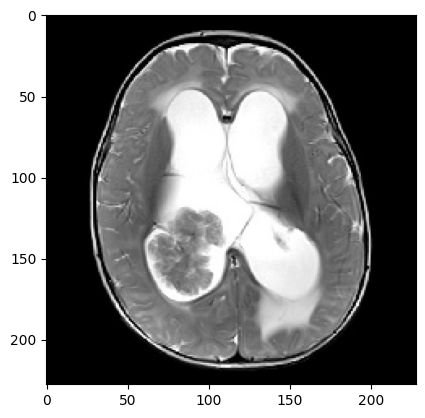


1/1 [==============================] - 0s 49ms/step
Predicted Class: Meduloblastoma


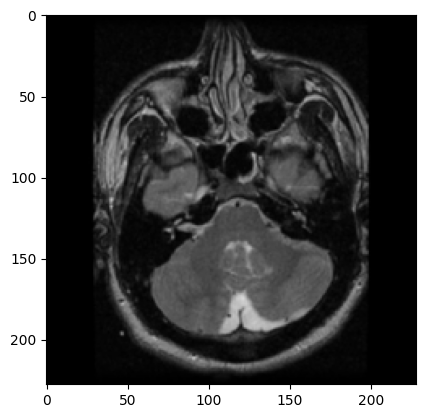


1/1 [==============================] - 0s 38ms/step
Predicted Class: Oligodendroglioma


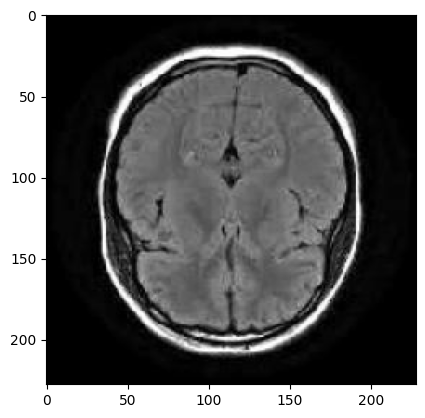


1/1 [==============================] - 0s 68ms/step
Predicted Class: Normal


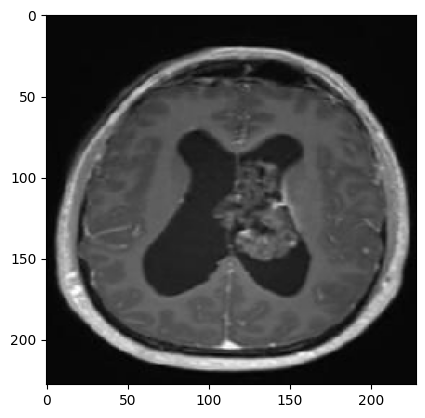


1/1 [==============================] - 0s 41ms/step
Predicted Class: Meningioma


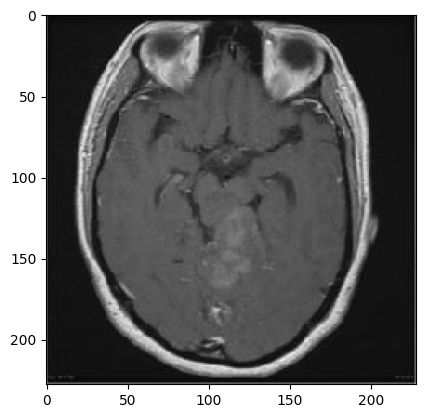

In [42]:
validation_generator = test_datagen.flow_from_directory(
        '/Users/its/Desktop/Major Project/data/val',
        target_size=target_size,
        batch_size=1,
        class_mode='categorical'
)

for _ in range(5):
    x = next(validation_generator)[0]
    predictions = model.predict(x)[0] 
    
    predicted_class_index = np.argmax(predictions)
    predicted_class = classes[predicted_class_index][1:]
    
    print('Predicted Class: ' + predicted_class)
    
    plt.imshow(x.reshape((228, 228, 3)))
    plt.show()
    print()

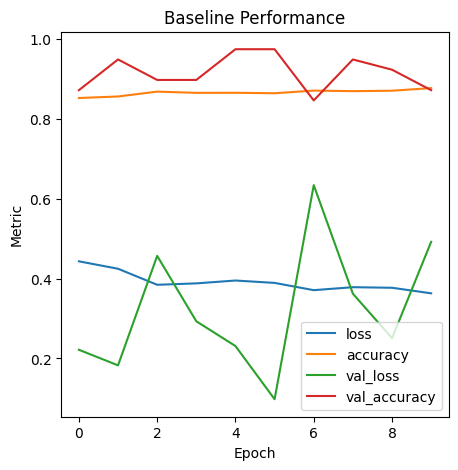

In [43]:
pd.DataFrame(history.history).plot(figsize=(5, 5))
plt.title('Baseline Performance')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.show()

The baseline is a weak model. Its loss doesn't gradually decrease and the validation loss is very erratic, spiking at epoch 6. Accuracy also doesn't improve with more training throughout the epochs.

<h1>VGG19 CNN<h1/>

In order to improve upon the baseline CNN, I use VGG19, which is an advanced network with pretrained layers and a better understanding of what defines an image in terms of shape, color, and structure. VGG19 is very deep and has been trained on millions of diverse images with complex classification tasks.

VGG19 consists of 19 layers:

16 convolution layers
5 MaxPool layers
1 SoftMax layer
3 fully connected layers
I extract the general structure of VGG19, freeze its initial layers and append a small dense network to it.


In [44]:
cnn_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(228, 228, 3)
                )
print(cnn_base.summary())

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 228, 228, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 228, 228, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 228, 228, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 114, 114, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 114, 114, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 114, 114, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 57, 57, 128)       0     

In [66]:
batch_size = 64
nb_train_samples = 17796
nb_validation_samples = 1274
nb_test_samples = 0
for cl in classes:
    nb_test_samples += len(os.listdir('data/test'+cl))
print(nb_test_samples)

1280


In [67]:
from tensorflow.keras.utils import to_categorical

def extract_features(directory, sample_amount):
    features = np.zeros(shape=(sample_amount, 7, 7, 512)) 
    labels = np.zeros(shape=(sample_amount, 15))
    
    datagen = ImageDataGenerator(rescale=1./255) 
    generator = datagen.flow_from_directory(
        directory, 
        target_size=(228, 228), 
        batch_size = batch_size, 
        class_mode='categorical'
    )
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = cnn_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_amount:
            break
    return features, labels

In [68]:
train_features, train_labels = extract_features(train_folder, nb_train_samples) 
validation_features, validation_labels = extract_features(val_folder, nb_validation_samples) 
test_features, test_labels = extract_features(test_folder, nb_test_samples)

Found 17796 images belonging to 15 classes.
1/1 [==============================] - 1s 814ms/step
Found 1274 images belonging to 15 classes.
2/2 [==============================] - 11s 5s/step
Found 1280 images belonging to 15 classes.
2/2 [==============================] - 15s 9s/step


2/2 [==============================] - 15s 7s/step


In [69]:
reshape_y = 7 * 7 * 512
train_features = np.reshape(train_features, (nb_train_samples, reshape_y))
validation_features = np.reshape(validation_features, (nb_validation_samples, reshape_y))
test_features = np.reshape(test_features, (nb_test_samples, reshape_y))

In [70]:
# Save features and labels

os.mkdir('data/bottlenecked')
np.save('data/bottlenecked/train_features.npy', train_features)
np.save('data/bottlenecked/train_labels.npy', train_labels)
np.save('data/bottlenecked/validation_features.npy', validation_features)
np.save('data/bottlenecked/validation_labels.npy', validation_labels)
np.save('data/bottlenecked/test_features.npy', test_features)
np.save('data/bottlenecked/test_labels.npy', test_labels)

**Validation**

**VGG 1 (2 Dense)**

In [72]:
# Build classifier on top of  VGG19
model = Sequential()

# Add dense layers on top of VGG19 
# 1
model.add(Dense(256, activation='relu', input_dim=reshape_y))
# 2
model.add(Dense(15, activation='softmax'))

# Compile
model.compile(
     #We can use adam for Stochastic Optimization or Optimized way of performing gradient descent
    optimizer=optimizers.RMSprop(lr=1e-4),
    loss='categorical_crossentropy', #Cross Entropy
    metrics=['acc'] 
)

history = model.fit(
    train_features, 
    train_labels,
    epochs=20,
    batch_size=16,
    validation_data=(validation_features, validation_labels)
)
                

# Save VGG19 results
model.save('models/model_VGG_01.h5')

Epoch 1/20
1113/1113 [==============================] - 55s 48ms/step - loss: 0.8716 - acc: 0.7247 - val_loss: 0.5593 - val_acc: 0.8155
Epoch 2/20
1113/1113 [==============================] - 60s 54ms/step - loss: 0.3273 - acc: 0.8992 - val_loss: 0.5029 - val_acc: 0.8344
Epoch 3/20
1113/1113 [==============================] - 59s 53ms/step - loss: 0.1787 - acc: 0.9474 - val_loss: 0.3166 - val_acc: 0.9042
Epoch 4/20
1113/1113 [==============================] - 57s 51ms/step - loss: 0.1152 - acc: 0.9663 - val_loss: 0.2466 - val_acc: 0.9262
Epoch 5/20
1113/1113 [==============================] - 59s 53ms/step - loss: 0.0736 - acc: 0.9781 - val_loss: 0.9382 - val_acc: 0.7088
Epoch 6/20
1113/1113 [==============================] - 68s 61ms/step - loss: 0.0527 - acc: 0.9848 - val_loss: 0.4250 - val_acc: 0.8752
Epoch 7/20
1113/1113 [==============================] - 72s 65ms/step - loss: 0.0376 - acc: 0.9898 - val_loss: 0.1393 - val_acc: 0.9647
Epoch 8/20
1113/1113 [==========================

We went from a 88.70% accuracy and 36.31% loss in the baseline model, to an accuracy of 99.93% and loss of .28% in epoch 20 of VGG19-1.

Let's see our training history and try several more versions of VGG19 to potentially yield a better outcome. Though, this one will be hard to beat.

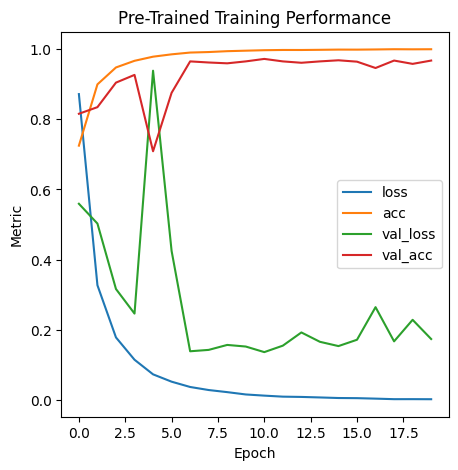

In [73]:
# Print training history

pd.DataFrame(history.history).plot(figsize=(5, 5))
plt.title('Pre-Trained Training Performance')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.show()

We notice validation loss and validation accuracy start to improve after the first few epochs. I will tweak some hyperparameters to improve how the model trains and print some prediction examples.

In [74]:
validation_generator = test_datagen.flow_from_directory(
        'data/val',
        target_size=(228, 228),
        batch_size=16,
        class_mode='binary'
)

Found 1274 images belonging to 15 classes.


1/1 [==============================] - 0s 96ms/step
Predicted Class: Oligodendroglioma


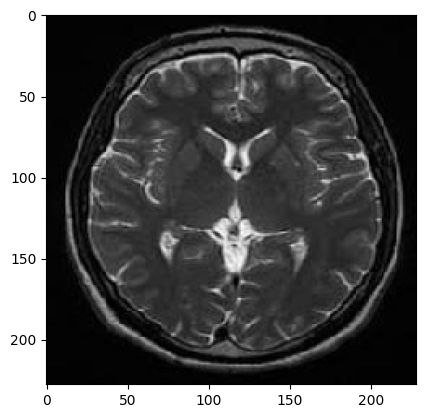


1/1 [==============================] - 0s 30ms/step
Predicted Class: Astrocitoma


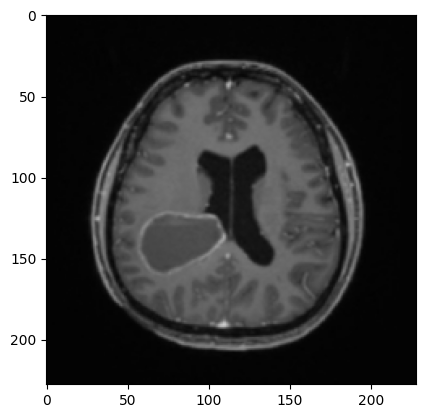


1/1 [==============================] - 0s 47ms/step
Predicted Class: Neurocitoma


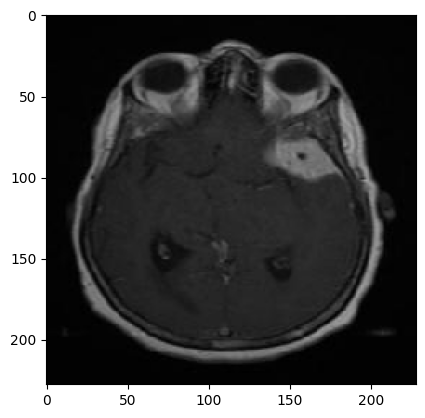


1/1 [==============================] - 0s 57ms/step
Predicted Class: Oligodendroglioma


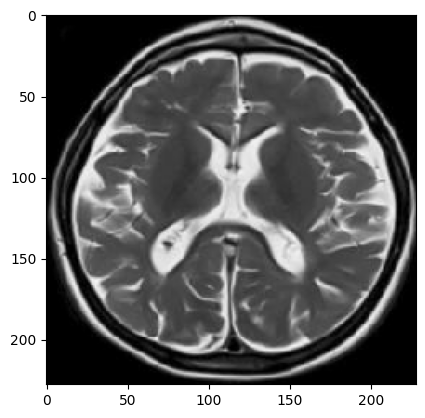


1/1 [==============================] - 0s 23ms/step
Predicted Class: Neurocitoma


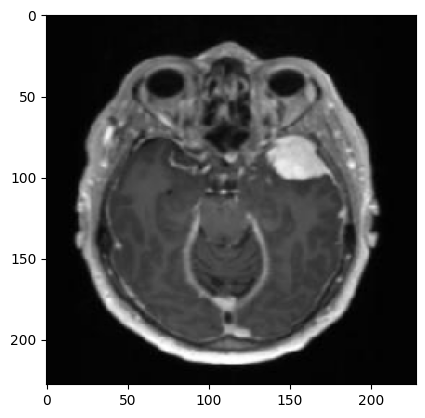


1/1 [==============================] - 0s 40ms/step
Predicted Class: Tuberculoma


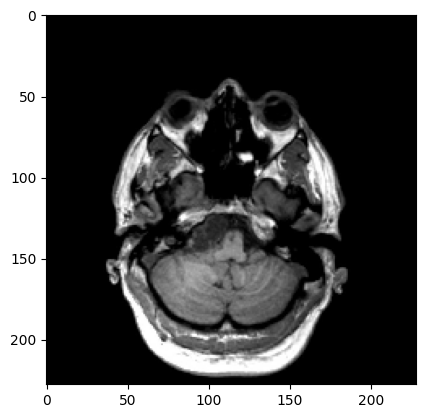


1/1 [==============================] - 0s 43ms/step
Predicted Class: Oligodendroglioma


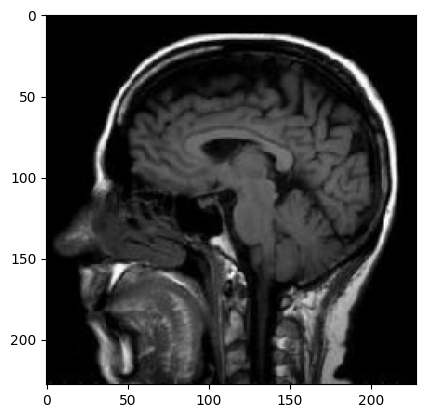


1/1 [==============================] - 0s 49ms/step
Predicted Class: Astrocitoma


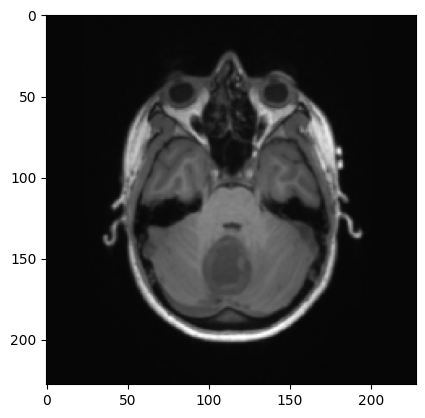


1/1 [==============================] - 0s 27ms/step
Predicted Class: Neurocitoma


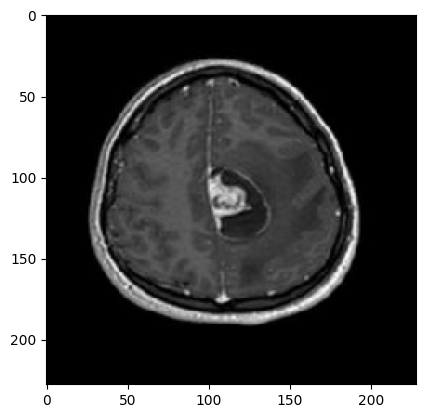


1/1 [==============================] - 0s 50ms/step
Predicted Class: Astrocitoma


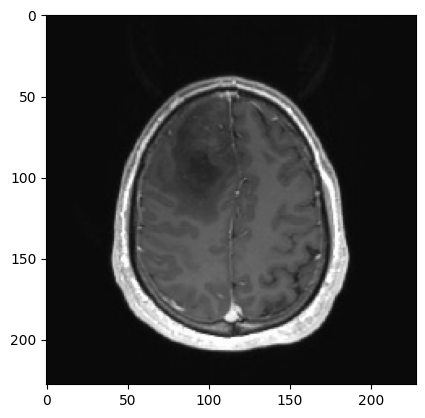

In [75]:
i=0
x = next(validation_generator)
for i in range(i, i + 10):
    cnn_pred = cnn_base.predict(x[0][i%10].reshape(1, 228, 228, 3)).flatten().reshape(1, -1)
    predictions = model.predict(cnn_pred)
    
    predicted_class_index = np.argmax(predictions)
    predicted_class = classes[predicted_class_index][1:]
    print('Predicted Class: ' + predicted_class)
    
    plt.imshow(x[0][i%10].reshape((228, 228, 3)))
    plt.show()
    print()
i += 10

Dropout is a technique where randomly selected neurons are ignored during training in order to improve model efficiency. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied on the backward pass.

In [76]:
# Reload data
train_features = np.load('data/bottlenecked/train_features.npy')
train_labels = np.load('data/bottlenecked/train_labels.npy')
validation_features = np.load('data/bottlenecked/validation_features.npy')
validation_labels = np.load('data/bottlenecked/validation_labels.npy')

In [77]:
train_features.shape

(17796, 25088)

**VGG 2 (3 Dense 1 Dropout)**

In [78]:
count = 2

C:\Users\its\AppData\Roaming\Python\Python311\site-packages\keras\optimizers\legacy\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
1113/1113 [==============================] - 56s 49ms/step - loss: 1.1622 - acc: 0.6470 - val_loss: 0.7070 - val_acc: 0.7826
Epoch 2/20
1113/1113 [==============================] - 52s 47ms/step - loss: 0.5477 - acc: 0.8374 - val_loss: 0.4584 - val_acc: 0.8642
Epoch 3/20
1113/1113 [==============================] - 60s 54ms/step - loss: 0.3357 - acc: 0.8974 - val_loss: 0.3193 - val_acc: 0.9035
Epoch 4/20
1113/1113 [==============================] - 59s 53ms/step - loss: 0.2275 - acc: 0.9310 - val_loss: 0.2215 - val_acc: 0.9419
Epoch 5/20
1113/1113 [==============================] - 51s 45ms/step - loss: 0.1594 - acc: 0.9494 - val_loss: 0.1970 - val_acc: 0.9505
Epoch 6/20
1113/1113 [==============================] - 51s 46ms/step - loss: 0.1213 - acc: 0.9626 - val_loss: 0.1845 - val_acc: 0.9529
Epoch 7/20
1113/1113 [==============================] - 56s 50ms/step - loss: 0.0937 - acc: 0.9711 - val_loss: 0.1923 - val_acc: 0.9529
Epoch 8/20
1113/1113 [==========================

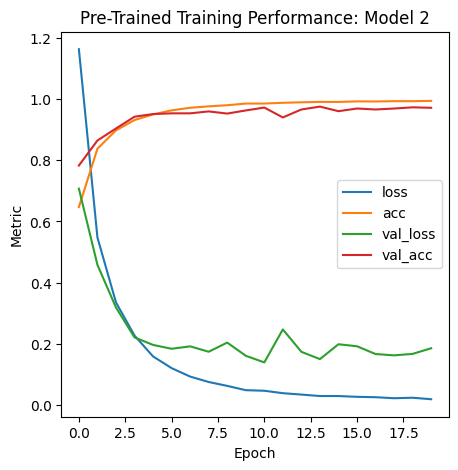

In [79]:
# Deeper VGG19 network
model = Sequential()

# 1
model.add(Dense(256, activation='relu', input_dim=train_features.shape[1]))

# 2
model.add(Dropout(0.2))

# 3
model.add(Dense(64, activation='relu'))

# 4
model.add(Dense(15, activation='softmax'))

model.compile(
    optimizer=optimizers.RMSprop(lr=1e-4),
    loss='categorical_crossentropy',
    metrics=['acc']
)

history = model.fit(
    train_features, 
    train_labels,
    epochs=20,
    batch_size=16,
    validation_data=(validation_features, validation_labels)
)

model.save(f'models/model_VGG_0{count}.h5')
pd.DataFrame(history.history).plot(figsize=(5, 5))
plt.title(f'Pre-Trained Training Performance: Model {count}')
plt.xlabel('Epoch')
plt.ylabel('Metric')
count += 1
plt.show()

Our second model performs slightly worse, with its highest accuracy peaking at 99.37% and loss at 1.97% in epoch 20. We know that the learning rate for deeper networks is so small, so the network might have gotten stuck at a local minimum instead of finding the real lowest minimum (the weight space in deeper architecture is smoother and has very vast "valleys" with local minimas). Dropout sometimes solves this problem, but not in this case. Let's try increasing the learning rate.

**VGG 3 (LR 1e-2)**

Epoch 1/20
1113/1113 [==============================] - 57s 50ms/step - loss: 3.1933 - acc: 0.2914 - val_loss: 2.1951 - val_acc: 0.2967
Epoch 2/20
1113/1113 [==============================] - 59s 53ms/step - loss: 2.1951 - acc: 0.2974 - val_loss: 2.1965 - val_acc: 0.2967
Epoch 3/20
1113/1113 [==============================] - 60s 54ms/step - loss: 2.2069 - acc: 0.2973 - val_loss: 2.1955 - val_acc: 0.2967
Epoch 4/20
1113/1113 [==============================] - 61s 54ms/step - loss: 2.2024 - acc: 0.2974 - val_loss: 2.1972 - val_acc: 0.2967
Epoch 5/20
1113/1113 [==============================] - 63s 57ms/step - loss: 2.2065 - acc: 0.2973 - val_loss: 2.1973 - val_acc: 0.2967
Epoch 6/20
1113/1113 [==============================] - 61s 55ms/step - loss: 2.1955 - acc: 0.2975 - val_loss: 2.1977 - val_acc: 0.2967
Epoch 7/20
1113/1113 [==============================] - 60s 54ms/step - loss: 2.2019 - acc: 0.2975 - val_loss: 2.1975 - val_acc: 0.2967
Epoch 8/20
1113/1113 [==========================

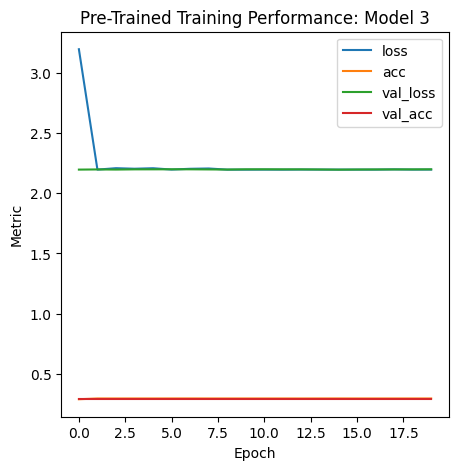

In [81]:
# Reduce learning rate to 1e-2
model = Sequential()

# 1
model.add(Dense(256, activation='relu', input_dim=train_features.shape[1]))

# 2
model.add(Dropout(0.2))

# 3
model.add(Dense(64, activation='relu'))

# 4
model.add(Dense(15, activation='softmax'))

model.compile(
    optimizer=optimizers.RMSprop(lr=1e-2),
    loss='categorical_crossentropy',
    metrics=['acc'],
)

history = model.fit(
    train_features, 
    train_labels,
    epochs=20,
    batch_size=16,
    validation_data=(validation_features, validation_labels)
)

model.save(f'models/model_VGG_0{count}.h5')

pd.DataFrame(history.history).plot(figsize=(5, 5))
plt.title(f'Pre-Trained Training Performance: Model {count}')
plt.xlabel('Epoch')
plt.ylabel('Metric')

count += 1
plt.show()

Increasing the learning rate smoothed out our plot, but our performance isn't better yet. Next I will try a different optimizer, Adam.

**VGG 4 (Adam)**

Epoch 1/20
1113/1113 [==============================] - 83s 74ms/step - loss: 1.2873 - acc: 0.6077 - val_loss: 0.8632 - val_acc: 0.7261
Epoch 2/20
1113/1113 [==============================] - 79s 71ms/step - loss: 0.7742 - acc: 0.7560 - val_loss: 0.6366 - val_acc: 0.7967
Epoch 3/20
1113/1113 [==============================] - 78s 70ms/step - loss: 0.5584 - acc: 0.8187 - val_loss: 0.4937 - val_acc: 0.8501
Epoch 4/20
1113/1113 [==============================] - 79s 71ms/step - loss: 0.5166 - acc: 0.8279 - val_loss: 0.4636 - val_acc: 0.8658
Epoch 5/20
1113/1113 [==============================] - 77s 69ms/step - loss: 0.4298 - acc: 0.8522 - val_loss: 0.3460 - val_acc: 0.8964
Epoch 6/20
1113/1113 [==============================] - 71s 63ms/step - loss: 0.4215 - acc: 0.8553 - val_loss: 0.3028 - val_acc: 0.9207
Epoch 7/20
1113/1113 [==============================] - 72s 64ms/step - loss: 0.4005 - acc: 0.8621 - val_loss: 0.2981 - val_acc: 0.9207
Epoch 8/20
1113/1113 [==========================

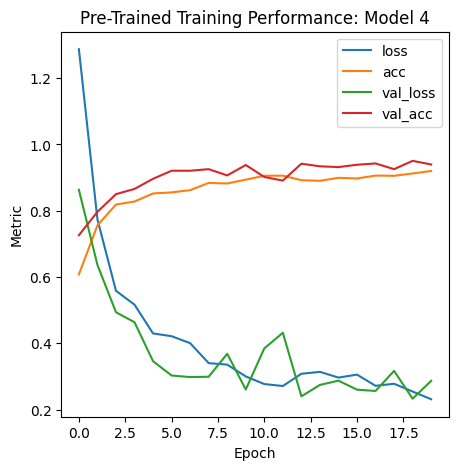

In [82]:
# Try adam optimizer
model = Sequential()

# 1
model.add(Dense(256, activation='relu', input_dim=train_features.shape[1]))

# 2
model.add(Dropout(0.2))

# 3
model.add(Dense(64, activation='relu'))

# 4
model.add(Dense(15, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc']
)

history = model.fit(
    train_features, 
    train_labels,
    epochs=20,
    batch_size=16,
    validation_data=(validation_features, validation_labels)
)

model.save(f'models/model_VGG_0{count}.h5')
pd.DataFrame(history.history).plot(figsize=(5, 5))
plt.title(f'Pre-Trained Training Performance: Model {count}')
plt.xlabel('Epoch')
plt.ylabel('Metric')

count += 1
plt.show()

Adam is a good alternative to relu, but accuracy is still not better than our first model. A shallow network might be the best bet here. Next, I will try another shallow network with a dropout layer.

**VGG 5 (2 Dense & Dropout)**

C:\Users\its\AppData\Roaming\Python\Python311\site-packages\keras\optimizers\legacy\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
1113/1113 [==============================] - 64s 56ms/step - loss: 1.6696 - acc: 0.4897 - val_loss: 1.2628 - val_acc: 0.6499
Epoch 2/20
1113/1113 [==============================] - 58s 52ms/step - loss: 1.1418 - acc: 0.6740 - val_loss: 0.9740 - val_acc: 0.7292
Epoch 3/20
1113/1113 [==============================] - 56s 51ms/step - loss: 0.9248 - acc: 0.7420 - val_loss: 0.8240 - val_acc: 0.7700
Epoch 4/20
1113/1113 [==============================] - 60s 54ms/step - loss: 0.7896 - acc: 0.7819 - val_loss: 0.7285 - val_acc: 0.8038
Epoch 5/20
1113/1113 [==============================] - 55s 49ms/step - loss: 0.6900 - acc: 0.8091 - val_loss: 0.6507 - val_acc: 0.8116
Epoch 6/20
1113/1113 [==============================] - 54s 49ms/step - loss: 0.6091 - acc: 0.8327 - val_loss: 0.5865 - val_acc: 0.8516
Epoch 7/20
1113/1113 [==============================] - 54s 48ms/step - loss: 0.5455 - acc: 0.8522 - val_loss: 0.5331 - val_acc: 0.8650
Epoch 8/20
1113/1113 [==========================

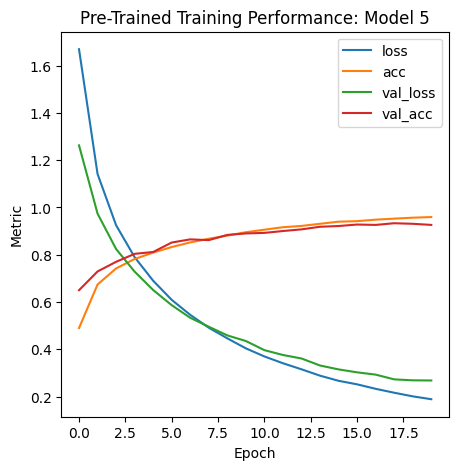

In [83]:
# Shallower network
model = Sequential()

# 1
model.add(Dense(256, activation='relu', input_dim=train_features.shape[1]))

# 2
model.add(Dropout(0.2))

# 3
model.add(Dense(15, activation='softmax'))

model.compile(
    optimizer=optimizers.RMSprop(lr=5e-6),
    loss='categorical_crossentropy',
    metrics=['acc']
)

history = model.fit(
    train_features,
    train_labels,
    epochs=20,
    batch_size=16,
    validation_data=(validation_features, validation_labels)
)

model.save(f'models/model_VGG_0{count}.h5')
pd.DataFrame(history.history).plot(figsize=(5, 5))
plt.title(f'Pre-Trained Training Performance: Model {count}')
plt.xlabel('Epoch')
plt.ylabel('Metric')

count += 1
plt.show()

This model trained well with loss dropping to 18.86% and increasing accuracy increasing to 95.94% in epoch 20. But we still can't seem to break that .28% loss and 99.93% accuracy from the first model. It looks like we maxed out performance on the first try.

**Testing**

Metrics:

Accuracy (TP+TN/TP+FP+FN+TN): Accuracy is the ratio of correctly predicted observations to the total observations. This is the ratio of correctly predicted images with brain tumor and images without tumor, out of the total population of images.

Precision (TP/TP+FP): Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. This is the ratio of correctly predicted images with tumor out of all images.

Recall (TP/TP+FN): Recall is the ratio of correctly predicted positive observations to the all observations in actual class. Or, all images with tumors, out of all images that actually had tumor (some of which were FN or photos with tumor that were missed by the model).

F1 (2x(Recall x Precision) / (Recall + Precision)): F1 Score is the weighted average of Precision and Recall, thereby taking both false positives and false negatives into account. F1 ranges from 0 to 1, with a better score being higher.

Which metric matters?

The best metric for model comparison is accuracy since we are mainly focused with being correct in identifying brain tumors, rather than reducing the number of false positives vs. false negatives.

Below We will compare the performance of the baseline (using ImageDataGenerator) to the VGG19 models (using the preloaded numpy array containing the weights).

**Baseline Model Test**

In [84]:
# Sort models
print(os.listdir('models'))
print(sorted(os.listdir('models')))

['model_01.h5', 'model_VGG_01.h5', 'model_VGG_02.h5', 'model_VGG_03.h5', 'model_VGG_04.h5', 'model_VGG_05.h5']
['model_01.h5', 'model_VGG_01.h5', 'model_VGG_02.h5', 'model_VGG_03.h5', 'model_VGG_04.h5', 'model_VGG_05.h5']


In [85]:
# Load baseline
model_baseline = load_model(('models/model_01.h5'))

In [86]:
# Load VGG Models
models_VGG = {model: load_model('models/' + model) for model in os.listdir('models')[0:] if model != 'model_01.h5'} 

In [87]:
# Confirm baseline 
model_baseline.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 226, 226, 32)      896       
                                                                 
 activation_5 (Activation)   (None, 226, 226, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 113, 113, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 111, 111, 32)      9248      
                                                                 
 activation_6 (Activation)   (None, 111, 111, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                  

In [88]:
# Get test images
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
                        'data/test',
                        target_size=(228, 228),
                        batch_size=16,
                        class_mode='categorical'
)

Found 1280 images belonging to 15 classes.


In [91]:
# Print baseline scores 
model_baseline.evaluate(
    test_generator,
    steps=1280 // 16
)

80/80 [==============================] - 7s 87ms/step - loss: 0.2760 - accuracy: 0.9242


[0.27603477239608765, 0.9242187738418579]

Our baseline achieved a 92.4218% accuracy on the test set. Let's now evaluate the VGG models.

**VGG19 Model Test**

In [92]:
# Get pretrained test features
test_features = np.load('data/bottlenecked/test_features.npy')
test_labels = np.load('data/bottlenecked/test_labels.npy')

In [93]:
# Print model scores
for model_name, model in models_VGG.items():
    print(model_name  + ' Evaluation')
    print(model.evaluate(test_features, test_labels))
    print()

model_VGG_01.h5 Evaluation
40/40 [==============================] - 1s 10ms/step - loss: 0.1447 - acc: 0.9703
[0.14466015994548798, 0.9703124761581421]

model_VGG_02.h5 Evaluation
40/40 [==============================] - 1s 12ms/step - loss: 0.1508 - acc: 0.9695
[0.15077351033687592, 0.969531238079071]

model_VGG_03.h5 Evaluation
40/40 [==============================] - 1s 11ms/step - loss: 2.2016 - acc: 0.2961
[2.201582193374634, 0.29609376192092896]

model_VGG_04.h5 Evaluation
40/40 [==============================] - 1s 8ms/step - loss: 0.2871 - acc: 0.9367
[0.28711122274398804, 0.936718761920929]

model_VGG_05.h5 Evaluation
40/40 [==============================] - 1s 11ms/step - loss: 0.2695 - acc: 0.9336
[0.26945680379867554, 0.93359375]



The **VGG19-1 model** had the highest overall accuracy at **97.03%**. The model with the lowest accuracy was VGG19-3 where we increased the learning rate so as to smooth out the plot.

In [94]:
# View model summary
best_model = models_VGG['model_VGG_01.h5']
best_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               6422784   
                                                                 
 dense_7 (Dense)             (None, 15)                3855      
                                                                 
Total params: 6,426,639
Trainable params: 6,426,639
Non-trainable params: 0
_________________________________________________________________


In [1]:
from sklearn.metrics import multilabel_confusion_matrix


# # Plot confusion matrix
# def plot_confusion_matrix(cm,
#                           target_names,
#                           title='Confusion Matrix',
#                           cmap=None,
#                           normalize=False):
#     for i in range(len(target_names)):
#         # Accuracy score
#         accuracy = np.trace(cm[i, :, :]) / float(np.sum(cm[i, :, :]))
#         misclass = 1 - accuracy
        
#         # Colormap gradient
#         if cmap is None:
#             cmap = plt.get_cmap('Blues')

#         plt.figure(figsize=(8, 6))
#         plt.imshow(cm[i, :, :], interpolation='nearest', cmap=cmap)
#         plt.title(f'{title} - Label {i}')
#         plt.colorbar()
        
#         # Show classification classes
#         if target_names is not None:
#             tick_marks = np.arange(len(target_names))
#             plt.xticks(tick_marks, target_names, rotation=45)
#             plt.yticks(tick_marks, target_names)
    
#         # Plot raw numbers or proportions
#         if normalize:
#             cm_normalized = cm[i, :, :].astype('float') / cm[i, :, :].sum(axis=1)[:, np.newaxis]

#         thresh = cm[i, :, :].max() / 1.5 if normalize else cm[i, :, :].max() / 2
        
#         # Text settings
#         for j, k in itertools.product(range(cm[i, :, :].shape[0]), range(cm[i, :, :].shape[1])):
#             if normalize:
#                 plt.text(k, j, "{:0.4f}".format(cm_normalized[j, k]),
#                      horizontalalignment="center",
#                      color="white" if cm_normalized[j, k] > thresh else "black")
#             else:
#                 plt.text(k, j, "{:,}".format(cm[i, j, k]),
#                      horizontalalignment="center",
#                      color="white" if cm[i, j, k] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel(f'Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}')
#     plt.show()

    


#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.show()

# y_test = test_labels

# # Predict probabilities
# y_pred = best_model.predict(test_features)
# y_score = (y_pred > 0.5).astype(int)
# cm = multilabel_confusion_matrix(y_test, y_score)
# plot_confusion_matrix(cm, classes)

40/40 [==============================] - 0s 12ms/step


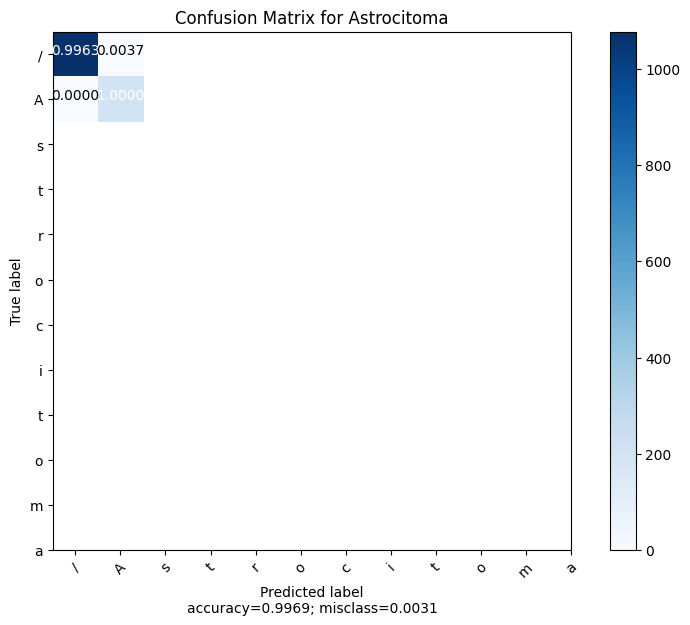

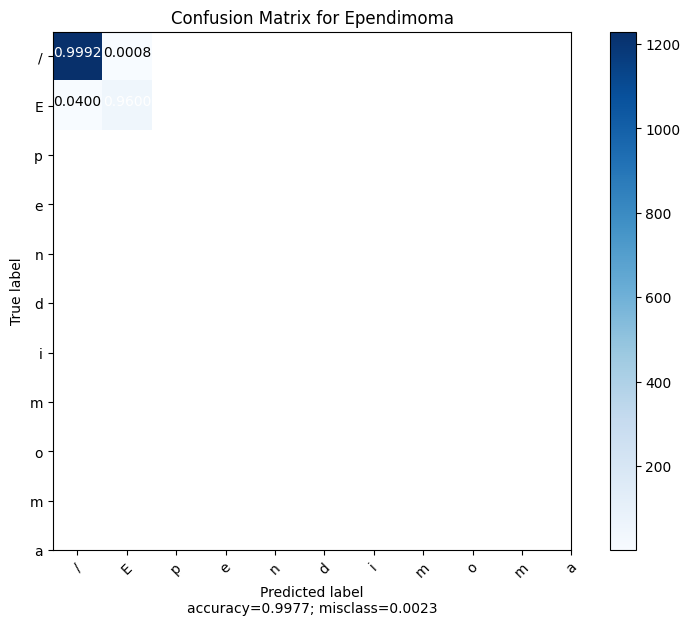

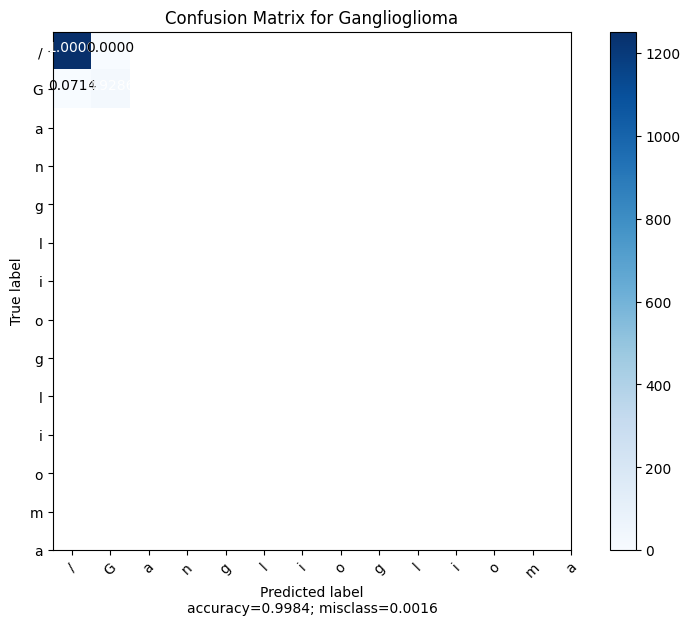

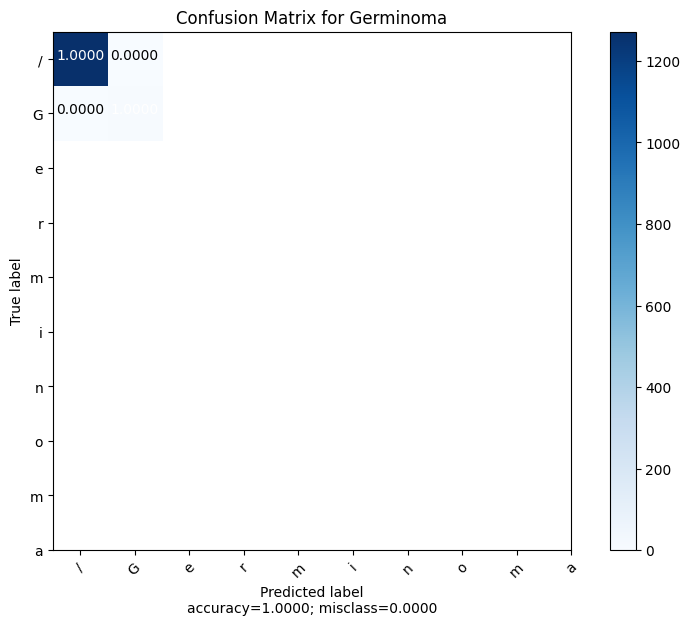

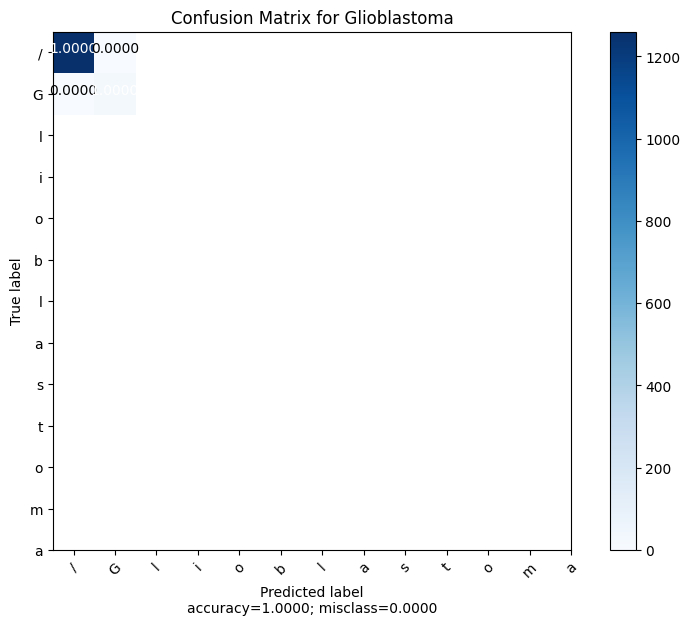

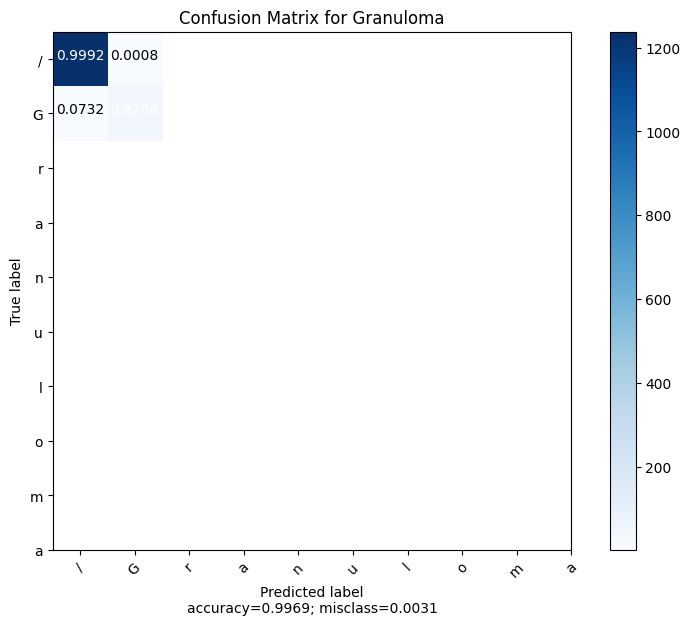

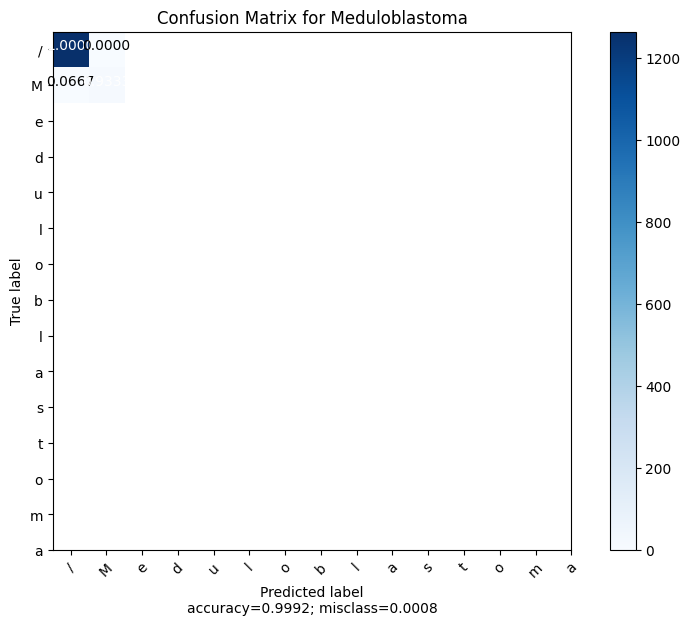

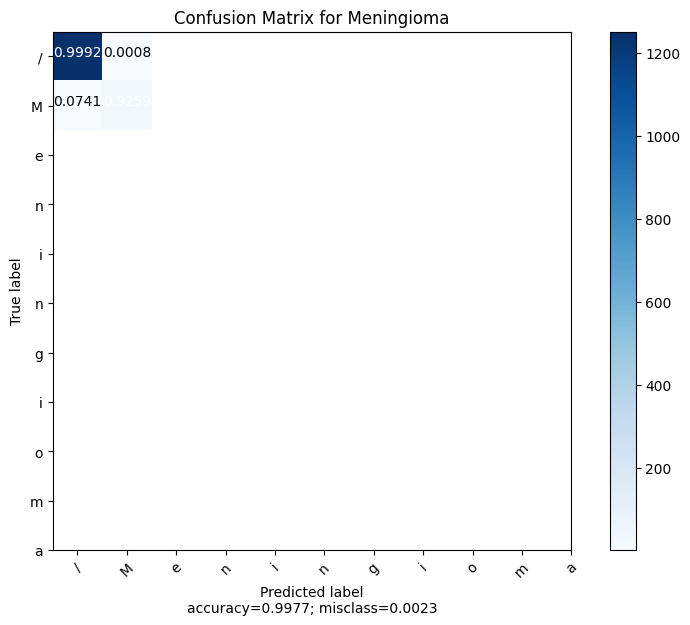

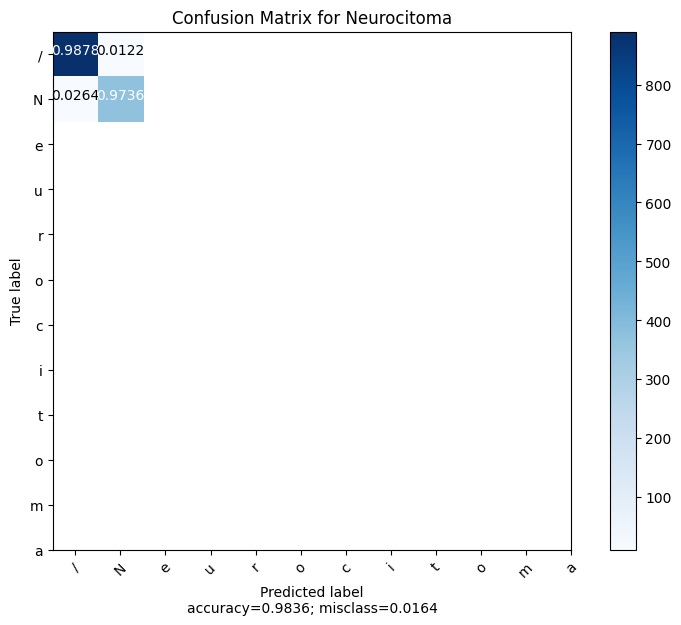

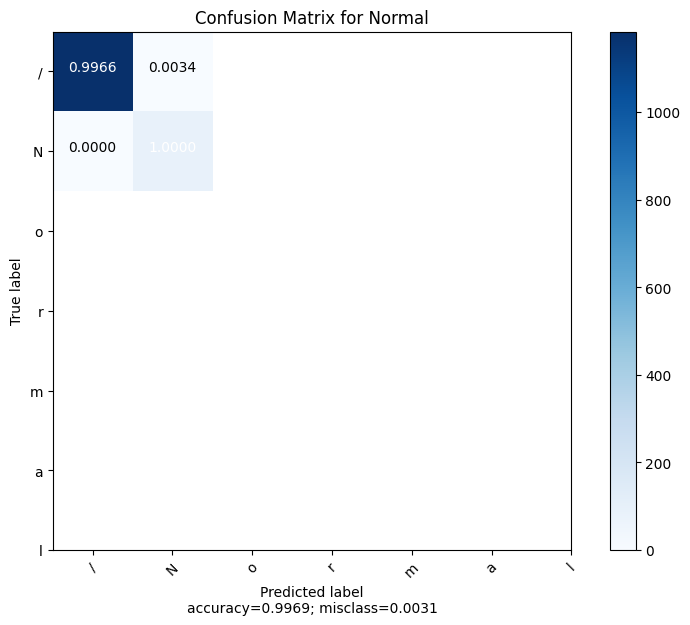

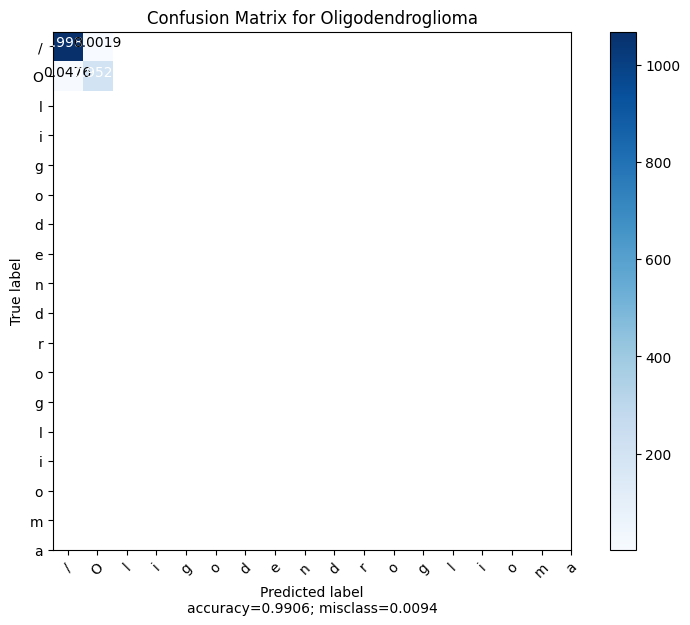

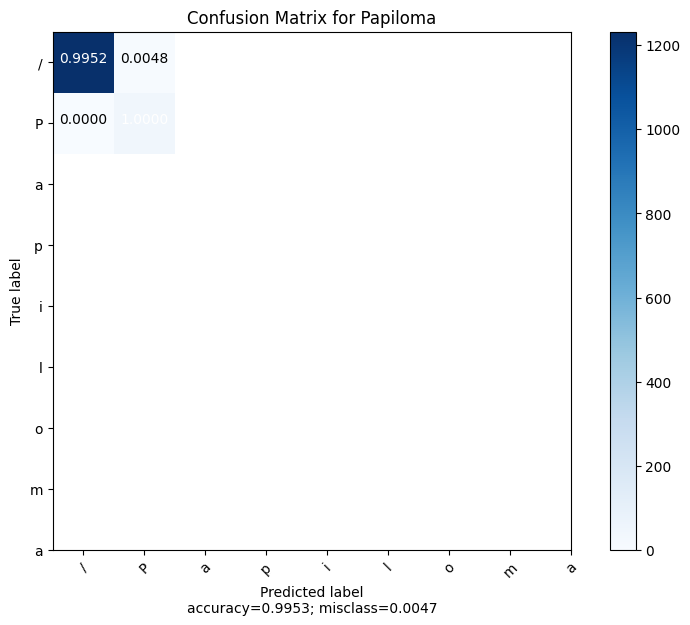

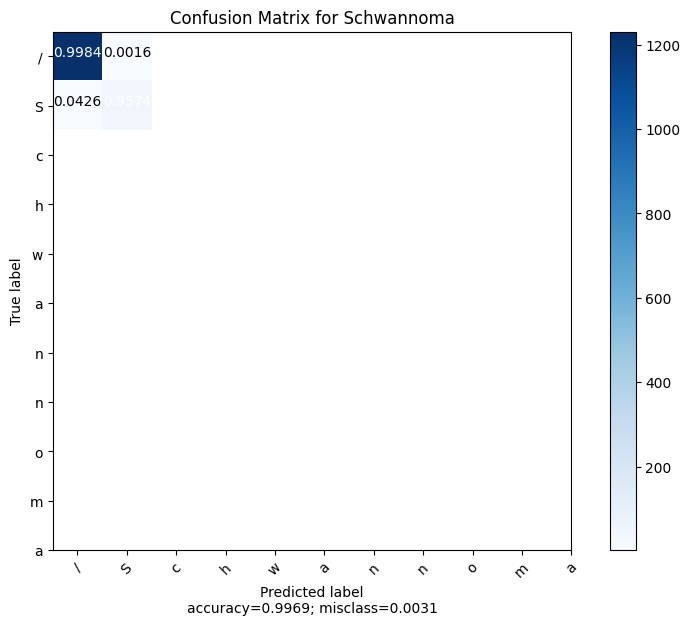

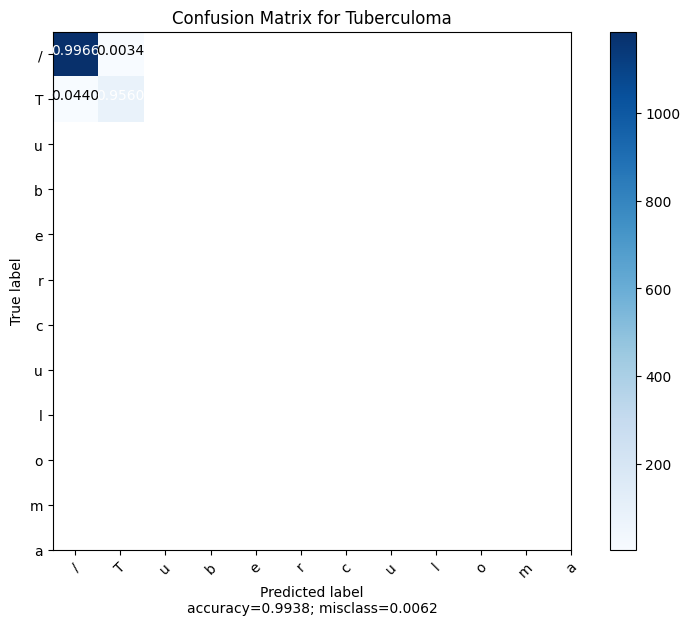

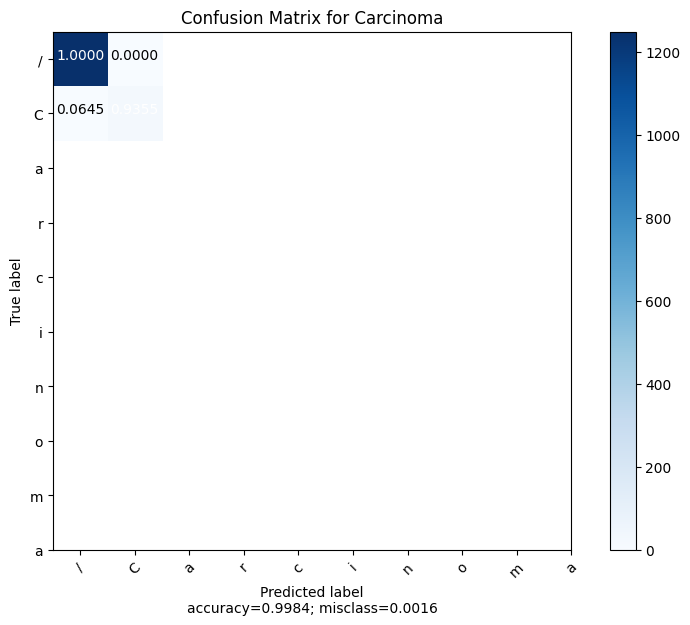

NameError: name 'figsize' is not defined

In [108]:
def plot_multilabel_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=None, normalize=False):
    
    for i in range(len(target_names)):
        plot_confusion_matrix(cm[i, :, :], 
                              target_names[i], 
                              title=f'Confusion Matrix for {classes[i][1:]}',
                              cmap=cmap,
                              normalize=normalize,
                             )
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize==(8, 6))  # Set the figsize parameter here

    # Rest of the function remains unchanged

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
    plt.show()


# Example usage
y_test = test_labels
y_pred = best_model.predict(test_features)
y_score = (y_pred > 0.5).astype(int)
cm = multilabel_confusion_matrix(y_test, y_score)
plot_multilabel_confusion_matrix(cm, target_names=classes, normalize=True)

In [115]:
# Print scores
print("Precision Score: ", precision_score(y_test, y_score, average='micro'))
print("Recall Score: ", recall_score(y_test, y_score, average='micro'))

Precision Score:  0.971830985915493
Recall Score:  0.9703125


In [118]:
# Get test images
test_datagen = ImageDataGenerator(rescale=1./255)
full_test_generator = test_datagen.flow_from_directory(
                        'data/test',
                        target_size=(228, 228),
                        batch_size=297,
                        class_mode='categorical'
)

Found 1280 images belonging to 15 classes.


In [1]:
# x = next(full_test_generator)

# for i in range(5):

#     cnn_pred = cnn_base.predict(x[0][i].reshape(1, 228, 228, 3)).flatten().reshape(1, -1)


#     full_pred = (best_model.predict(cnn_pred) <= 0.5)

#     # Check if the prediction matches the ground truth
#     if full_pred != int(x[1][i]):
#         # Print the predicted class label
#         predicted_class_label = classes[full_pred[0]]  # Assuming you have a list of class labels
#         print(predicted_class_label)

#         # Show the image
#         plt.imshow(x[0][i].reshape((228, 228, 3)))
#         plt.show()
#         print()

**Converting the h5 model to tflite model for integration in flutter**

In [4]:
import tensorflow as tf
model = keras.models.load_model('models/model_VGG_01.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [6]:
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\its\AppData\Local\Temp\tmphkdsoqce\assets


In [7]:
open('model.tflite','wb').write(tflite_model)

25708272

In [9]:
print(train_generator.class_indices)
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
    f.write(labels)

{'Astrocitoma': 0, 'Carcinoma': 1, 'Ependimoma': 2, 'Ganglioglioma': 3, 'Germinoma': 4, 'Glioblastoma': 5, 'Granuloma': 6, 'Meduloblastoma': 7, 'Meningioma': 8, 'Neurocitoma': 9, 'Normal': 10, 'Oligodendroglioma': 11, 'Papiloma': 12, 'Schwannoma': 13, 'Tuberculoma': 14}
